In [2]:
from yt_xarray import transformations
from yt_xarray.sample_data import load_random_xr_data
import numpy as np 

fields = {
        "field0": ("radius", "latitude", "longitude"),
    }
dims = {
    "radius": (2000, 5000, 32),
    "latitude": (10, 50, 32),
    "longitude": (10, 50, 22),
}
ds = load_random_xr_data(fields, dims)
ds_yt = transformations.build_interpolated_cartesian_ds(
    ds,
    [
        "field0",
    ],
    "radius",
)
ad = ds_yt.all_data()
mn = np.nanmin(ad[("stream", "field0")])
mx = np.nanmax(ad[("stream", "field0")])
mn, mx

yt : [INFO     ] 2024-01-31 11:16:30,718 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-01-31 11:16:30,719 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-01-31 11:16:30,719 Parameters: domain_left_edge          = [826.35182233 223.2377941  347.29635533]
yt : [INFO     ] 2024-01-31 11:16:30,720 Parameters: domain_right_edge         = [4849.23155196 3772.03253368 3830.22221559]
yt : [INFO     ] 2024-01-31 11:16:30,721 Parameters: cosmological_simulation   = 0


(unyt_quantity(0.00127586, '(dimensionless)'),
 unyt_quantity(0.99997241, '(dimensionless)'))

yt : [INFO     ] 2024-01-31 11:35:11,399 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-01-31 11:35:11,399 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-01-31 11:35:11,400 Parameters: domain_left_edge          = [-3270.59008789 -5572.16015625  2533.15649414]
yt : [INFO     ] 2024-01-31 11:35:11,401 Parameters: domain_right_edge         = [ -334.45635986 -2832.01171875  4869.72851562]
yt : [INFO     ] 2024-01-31 11:35:11,403 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-01-31 11:35:11,601 xlim = -3270.590088 -334.456360
yt : [INFO     ] 2024-01-31 11:35:11,602 ylim = -5572.160156 -2832.011719
yt : [INFO     ] 2024-01-31 11:35:11,605 xlim = -3270.590088 -334.456360
yt : [INFO     ] 2024-01-31 11:35:11,606 ylim = -5572.160156 -2832.011719
yt : [INFO     ] 2024-01-31 11:35:11,609 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800



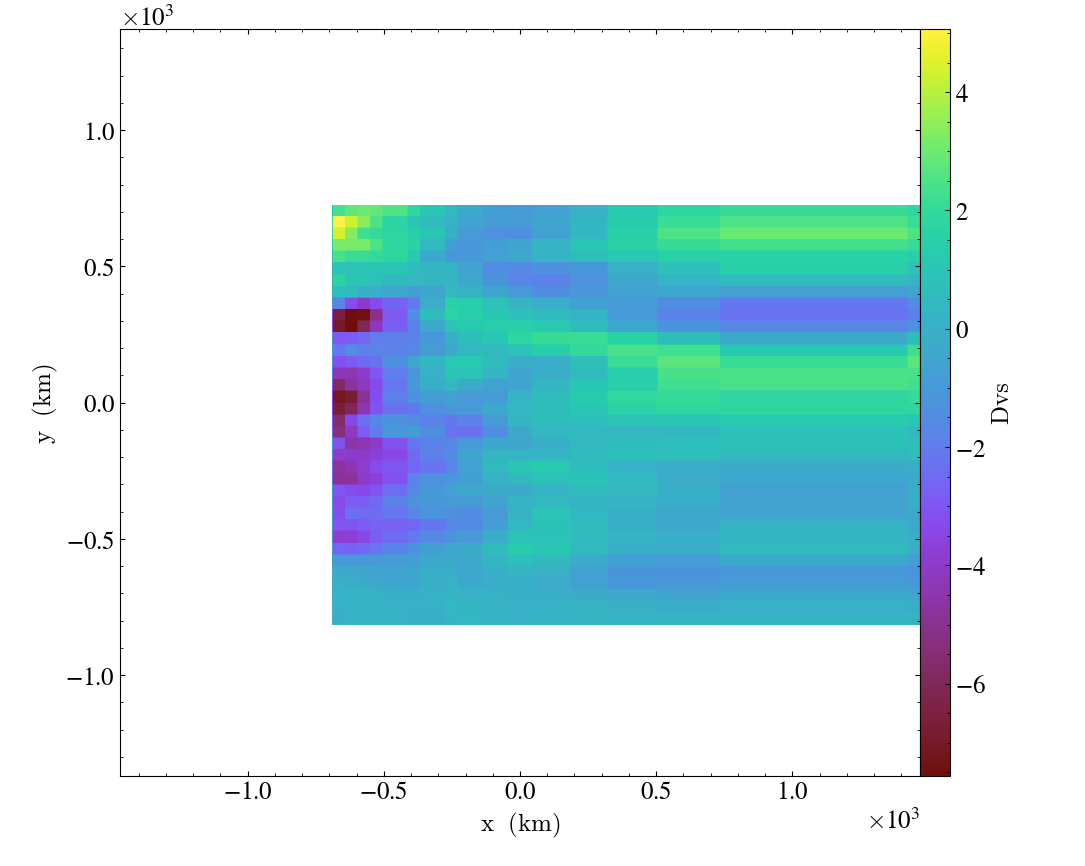

In [2]:
import xarray as xr
import yt_xarray
import yt
from yt_xarray import transformations

ds = yt_xarray.open_dataset("IRIS/wUS-SH-2010_percent.nc")
ds_yt = transformations.build_interpolated_cartesian_ds(
    ds,
    [
        "dvs",
    ],
    "depth",
)
slc = yt.SlicePlot(ds_yt,'z', ('stream', 'dvs'))
slc.set_log(("stream", "dvs"), False)

In [1]:
import xarray as xr
import yt_xarray
import yt
from yt_xarray import transformations
import numpy as np 
import napari 
from yt_napari.viewer import Scene


ds = yt_xarray.open_dataset("IRIS/wUS-SH-2010_percent.nc")
interp_res = (256,256,256)
ds_yt = transformations.build_interpolated_cartesian_ds(
    ds,
    [
        "dvs",
    ],
    "depth", 
    grid_resolution=interp_res,
)

def _slow_vels(field, data):
    # return negative velocities only, 0 all other elements
    dvs = data['dvs'].copy()
    dvs[np.isnan(dvs)] = 0.0
    dvs[dvs>0] = 0.0
    return np.abs(dvs)

def _fast_vels(field, data):
    # return fast velocities only, 0 all other elements
    dvs = data['dvs'].copy()
    dvs[np.isnan(dvs)] = 0.0
    dvs[dvs<0] = 0.0
    return np.abs(dvs)

ds_yt.add_field(    
    name=("stream", "slow_dvs"),
    function=_slow_vels,
    sampling_type="local",
)

ds_yt.add_field(    
    name=("stream", "fast_dvs"),
    function=_fast_vels,
    sampling_type="local",    
)


yt : [INFO     ] 2024-01-31 12:03:34,786 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-01-31 12:03:34,787 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-01-31 12:03:34,788 Parameters: domain_left_edge          = [-3270.59008789 -5572.16015625  2533.15649414]
yt : [INFO     ] 2024-01-31 12:03:34,788 Parameters: domain_right_edge         = [ -334.45635986 -2832.01171875  4869.72851562]
yt : [INFO     ] 2024-01-31 12:03:34,789 Parameters: cosmological_simulation   = 0


In [2]:
v = napari.viewer.Viewer()

In [3]:
yt_scene = Scene()

In [4]:
min_max = ds_yt.all_data().quantities.extrema(('stream', 'slow_dvs')).d
min_max

yt : [WARNING  ] 2024-01-31 12:03:38,173 Field ('stream', 'slow_dvs') was added without specifying units or dimensions, auto setting units to 'dimensionless'


array([ 0.        , 14.01000023])

In [8]:
yt_scene.add_region(v, ds_yt, 
                    ("stream", "slow_dvs"), 
                    resolution=interp_res, 
                    take_log=False, 
                    contrast_limits=min_max,
                    colormap='magma')
v.dims.ndisplay = 3 # switch to 3d display

In [ ]:
welrkj = 1